[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# Label Smoothing

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 04/06/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0096DeepLearningLabelSmoothing.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid

# Deep Learning
import torch
import torch.nn            as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchinfo
from torchmetrics.classification import MulticlassAccuracy
import torchvision
from torchvision.transforms import v2 as TorchVisionTrns

# Miscellaneous
import copy
from enum import auto, Enum, unique
import math
import os
from platform import python_version
import random
import shutil
import time

# Typing
from typing import Callable, Dict, Generator, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import HTML, Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

2024-06-14 06:29:10.330151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

# Improve performance by benchmarking
torch.backends.cudnn.benchmark = True

# Reproducibility (Per PyTorch Version on the same device)
# torch.manual_seed(seedNum)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark     = False #<! Makes things slower


In [3]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2

DATA_SET_FILE_NAME      = 'archive.zip'
DATA_SET_FOLDER_NAME    = 'IntelImgCls'

D_CLASSES  = {0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat', 4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}
L_CLASSES  = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
T_IMG_SIZE = (32, 32, 3)

DATA_FOLDER_PATH    = 'Data'
TENSOR_BOARD_BASE   = 'TB'


In [4]:
# Download Auxiliary Modules for Google Colab
if runInGoogleColab:
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataManipulation.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataVisualization.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DeepLearningPyTorch.py

In [5]:
# Courses Packages
import sys
sys.path.append('../../utils')
sys.path.append('/home/vlad/utils/')
from DataVisualization import PlotLabelsHistogram, PlotMnistImages
from DeepLearningPyTorch import ResidualBlock, TBLogger, TestDataSet
from DeepLearningPyTorch import InitWeightsKaiNorm, TrainModel, TrainModelSch


In [6]:
# General Auxiliary Functions

def GenResNetModel( trainedModel: bool, numCls: int, resNetDepth: int = 18 ) -> nn.Module:
    # Read on the API change at: How to Train State of the Art Models Using TorchVision’s Latest Primitives
    # https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives

    if (resNetDepth == 18):
        modelFun = torchvision.models.resnet18
        modelWeights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
    elif (resNetDepth == 34):
        modelFun = torchvision.models.resnet34
        modelWeights = torchvision.models.ResNet34_Weights.IMAGENET1K_V1
    else:
        raise ValueError(f'The `resNetDepth`: {resNetDepth} is invalid!')

    if trainedModel:
        oModel = modelFun(weights = modelWeights)
        numFeaturesIn   = oModel.fc.in_features
        # Assuming numCls << 100
        oModel.fc       = nn.Sequential(
            nn.Linear(numFeaturesIn, 128), nn.ReLU(),
            nn.Linear(128, numCls),
        )
    else:
        oModel = modelFun(weights = None, num_classes = numCls)

    return oModel



## Label Smoothing

The motivation for _Label Smoothing_ is avoiding numerical issues related to the $log$ function of the _Cross Entropy_ loss.

What's the contribution of Label Smoothing:

 - Makes the model less sensitive to "noisy labeling" (By limiting the loss).  
 - Regularizes the overfitting on correct examples.
 - Regularizes the "confidence" of the model and improves its calibration.

This notebook demonstrates the use of _Label Smoothing_ for image classification.

</br>

* <font color='brown'>(**#**)</font> _Label Smoothing_ is less effective in Binary Classification.  
  As its main contribution is by "clustering" the wrong labels together with equal probability it has little effect for the binary case.
* <font color='brown'>(**#**)</font> See
    * [When Does Label Smoothing Help](https://arxiv.org/abs/1906.02629).
    * [Delving Deep into Label Smoothing](https://arxiv.org/abs/2011.12562).
* <font color='brown'>(**#**)</font> [What is Label Smoothing](https://scribe.rip/108debd7ef06).
* <font color='brown'>(**#**)</font> [Lei Mao - Label Smoothing](https://leimao.github.io/blog/Label-Smoothing/).

In [7]:
# Parameters

# Data

# Model
dropP = 0.5 #<! Dropout Layer

# Training
batchSize   = 256
numWorkers  = 4 #<! Number of workers
numEpochs   = 5

# Visualization
numImg = 3


## Generate / Load Data

Load the [CIFAR 10 Data Set](https://en.wikipedia.org/wiki/CIFAR-10).  
It is composed of 60,000 RGB images of size `32x32` with 10 classes uniformly spread.

* <font color='brown'>(**#**)</font> The dataset is retrieved using [Torch Vision](https://pytorch.org/vision/stable/index.html)'s built in datasets.  


In [8]:
# Load Data

dsTrain = torchvision.datasets.CIFAR10(root = DATA_FOLDER_PATH, train = True,  download = True, transform = torchvision.transforms.ToTensor())
dsVal   = torchvision.datasets.CIFAR10(root = DATA_FOLDER_PATH, train = False, download = True, transform = torchvision.transforms.ToTensor())
lClass  = dsTrain.classes


print(f'The training data set data shape: {dsTrain.data.shape}')
print(f'The test data set data shape: {dsVal.data.shape}')
print(f'The unique values of the labels: {np.unique(lClass)}')

Files already downloaded and verified
Files already downloaded and verified
The training data set data shape: (50000, 32, 32, 3)
The test data set data shape: (10000, 32, 32, 3)
The unique values of the labels: ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


* <font color='brown'>(**#**)</font> The dataset is indexible (Subscriptable). It returns a tuple of the features and the label.
* <font color='brown'>(**#**)</font> While data is arranged as `H x W x C` the transformer, when accessing the data, will convert it into `C x H x W`. 

In [9]:
# Element of the Data Set

mX, valY = dsTrain[0]

print(f'The features shape: {mX.shape}')
print(f'The label value: {valY}')

The features shape: torch.Size([3, 32, 32])
The label value: 6


### Plot the Data

In [10]:
# Extract Data

tX = dsTrain.data #<! NumPy Tensor (NDarray)
mX = np.reshape(tX, (tX.shape[0], -1))
vY = dsTrain.targets #<! NumPy Vector


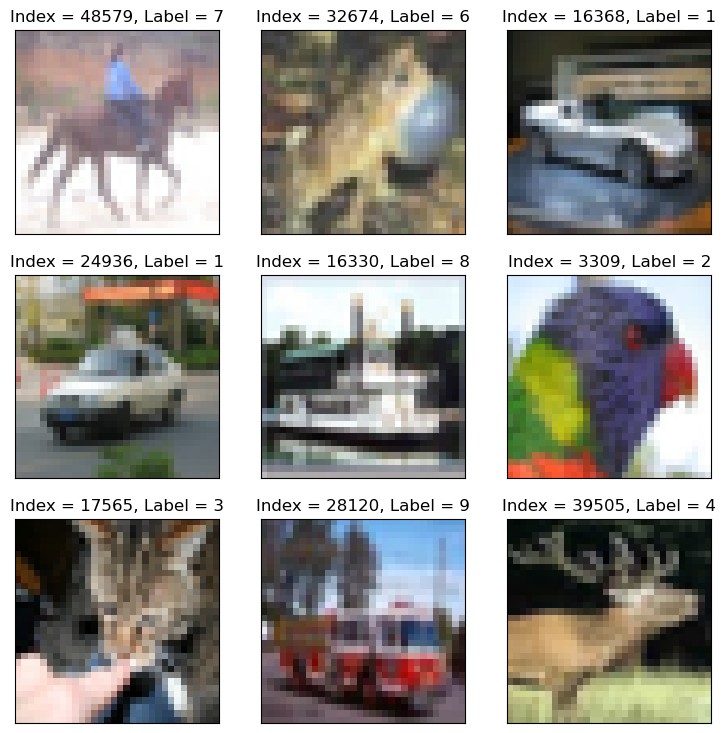

In [11]:
# Plot the Data

hF = PlotMnistImages(mX, vY, numImg, tuImgSize = T_IMG_SIZE)

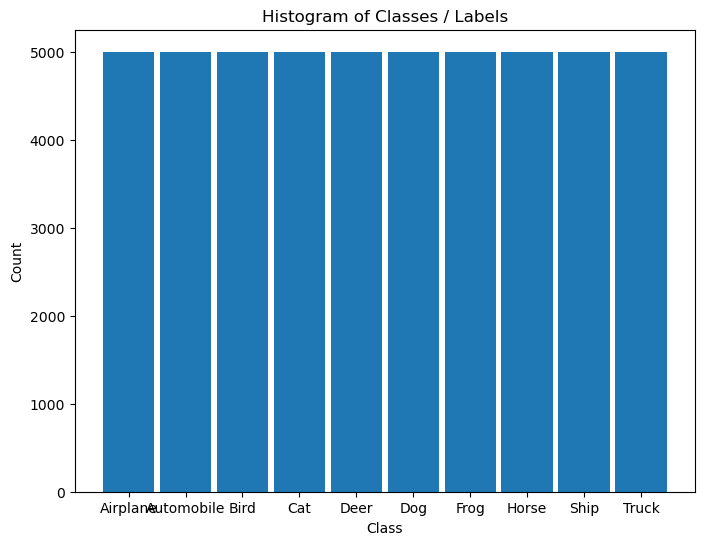

In [12]:
# Histogram of Labels

hA = PlotLabelsHistogram(vY, lClass = L_CLASSES)
plt.show()

* <font color='red'>(**?**)</font> If data is converted into _grayscale_, how would it effect the performance of the classifier? Explain.  
  You may assume the conversion is done using the mean value of the RGB pixel.

## Pre Process Data

This section normalizes the data to have zero mean and unit variance per **channel**.  
It is required to calculate:

 * The average pixel value per channel.
 * The standard deviation per channel.

</br>

* <font color='brown'>(**#**)</font> The values calculated on the train set and applied to both sets.
* <font color='brown'>(**#**)</font> The the data will be used to pre process the image on loading by the `transformer`.
* <font color='brown'>(**#**)</font> There packages which specializes in transforms: [`Kornia`](https://github.com/kornia/kornia), [`Albumentations`](https://github.com/albumentations-team/albumentations).  
  They are commonly used for _Data Augmentation_ at scale.

In [13]:
# Calculate the Standardization Parameters
vMean = np.mean(dsTrain.data / 255.0, axis = (0, 1, 2))
vStd  = np.std(dsVal.data / 255.0, axis = (0, 1, 2))

print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24665252 0.24289226 0.26159238]


In [14]:
# Update Transformer

oTrnsTrain = TorchVisionTrns.Compose([
    TorchVisionTrns.RandomHorizontalFlip(), #<! Can be done in UINT8 for faster performance
    TorchVisionTrns.AutoAugment(policy = TorchVisionTrns.AutoAugmentPolicy.CIFAR10), #<! Requires `UINT8`
    TorchVisionTrns.ToImage(),
    TorchVisionTrns.ToDtype(torch.float32, scale = True),
    TorchVisionTrns.Normalize(vMean, vStd)
])

oTrnsInfer = TorchVisionTrns.Compose([
    TorchVisionTrns.ToImage(),
    TorchVisionTrns.ToDtype(torch.float32, scale = True),
    TorchVisionTrns.Normalize(vMean, vStd)
])

# Update the DS transformer
dsTrain.transform   = oTrnsTrain
dsVal.transform     = oTrnsInfer

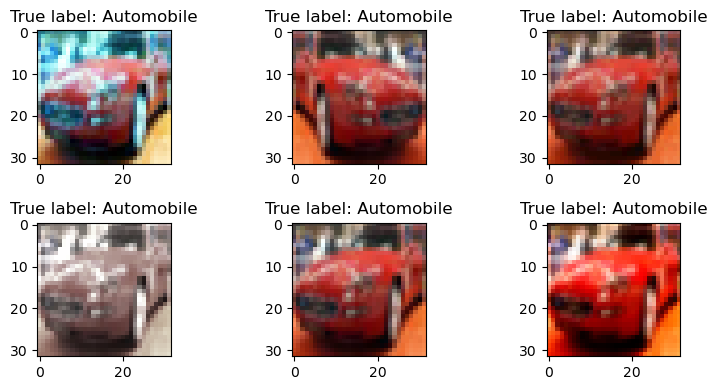

In [15]:
# "Normalized" Image

imgIdx = 5

N, H, W, C = dsTrain.data.shape
hF, vHA = plt.subplots(2, 3, figsize = (8, 4))
vHA = vHA.flat
for hA in vHA:
    mX, valY = dsTrain[imgIdx] #<! Random
    mX = torch.permute(mX, (1, 2, 0))
    hA.imshow(torch.clip(mX * vStd[None, None, :] + vMean[None, None, :], min = 0.0, max = 1.0))
    hA.set_title(f'True label: {L_CLASSES[valY]}')
    
hF.tight_layout()


### Data Loaders

This section defines the data loaded.



In [16]:
# Data Loader

dlTrain = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = 2, drop_last = True, persistent_workers = True)
dlVal   = torch.utils.data.DataLoader(dsVal, shuffle = False, batch_size = 2 * batchSize, num_workers = 2, persistent_workers = True)

# dlTrain = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = 0, drop_last = True)
# dlVal   = torch.utils.data.DataLoader(dsVal, shuffle = False, batch_size = 2 * batchSize, num_workers = 0)


In [17]:
# Iterate on the Loader
# The first batch.
tX, vY = next(iter(dlTrain)) #<! PyTorch Tensors

print(f'The batch features dimensions: {tX.shape}')
print(f'The batch labels dimensions: {vY.shape}')

The batch features dimensions: torch.Size([256, 3, 32, 32])
The batch labels dimensions: torch.Size([256])


In [18]:
# Looping
# for ii, (tX, vY) in zip(range(1), dlVal): #<! https://stackoverflow.com/questions/36106712
#     print(f'The batch features dimensions: {tX.shape}')
#     print(f'The batch labels dimensions: {vY.shape}')

## Load the Model

This section loads the model.  
The number of outputs is adjusted to match the number of classes in the data.

In [19]:
# Loading a Pre Defined Model
oModel = GenResNetModel(trainedModel = False, numCls = len(L_CLASSES))
# oModel.apply(InitWeightsKaiNorm)

In [20]:
# Model Information - Pre Defined
# Pay attention to the layers name.
torchinfo.summary(oModel, (batchSize, *(T_IMG_SIZE[::-1])), col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu', row_settings = ['depth', 'var_names'])

Layer (type (var_name):depth-idx)             Kernel Shape              Output Shape              Param #
ResNet (ResNet)                               --                        [256, 10]                 --
├─Conv2d (conv1): 1-1                         [7, 7]                    [256, 64, 16, 16]         9,408
├─BatchNorm2d (bn1): 1-2                      --                        [256, 64, 16, 16]         128
├─ReLU (relu): 1-3                            --                        [256, 64, 16, 16]         --
├─MaxPool2d (maxpool): 1-4                    3                         [256, 64, 8, 8]           --
├─Sequential (layer1): 1-5                    --                        [256, 64, 8, 8]           --
│    └─BasicBlock (0): 2-1                    --                        [256, 64, 8, 8]           --
│    │    └─Conv2d (conv1): 3-1               [3, 3]                    [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d (bn1): 3-2            --                        [256, 

* <font color='red'>(**?**)</font> Does the last (_Head_) dense layer includes a bias? Explain.

In [21]:
# Model
# Defining a sequential model.

# numChannels = 128

# def BuildModel( nC: int ) -> nn.Module:

#     oModel = nn.Sequential(
#         nn.Identity(),
#         nn.Conv2d(3, nC, 3, padding = 1, bias = False),  nn.BatchNorm2d(nC), nn.ReLU(),                  nn.Dropout2d(0.2),
#         nn.Conv2d(nC, nC, 3, padding = 1, bias = False), nn.BatchNorm2d(nC), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout2d(0.2),
        
#         ResidualBlock(nC), nn.Dropout2d(0.2),
#         ResidualBlock(nC), nn.Dropout2d(0.2),
#         ResidualBlock(nC), nn.Dropout2d(0.2),
#         ResidualBlock(nC), nn.Dropout2d(0.2),
#         ResidualBlock(nC), nn.Dropout2d(0.2),
        
#         nn.AdaptiveAvgPool2d(1),
#         nn.Flatten(),
#         nn.Linear(nC, 10)
#     )

#     oModel.apply(InitWeightsKaiNorm)

#     return oModel

# oModel = BuildModel(numChannels)

# torchinfo.summary(oModel, (batchSize, 3, 32, 32), col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu')

## Train the Model

This section trains the model.  
It compares results with and without _Label Smoothing_.

* <font color='brown'>(**#**)</font> The objective is to show how to apply _Label Smoothing_.  

### Label Smoothing

* Cross Entropy Loss
$$
\ell_{\mathrm{CE}}\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)=-\left\langle \boldsymbol{y}_{i},\log\left(\hat{\boldsymbol{y}}_{i}\right)\right\rangle =-\left\langle \left[\begin{matrix}0\\
1\\
0\\
0
\end{matrix}\right],\log\left(\left[\begin{matrix}0.1\\
0.75\\
0.05\\
0.1
\end{matrix}\right]\right)\right\rangle 
$$
* Label Smoothing Loss
$$
\ell_{\mathrm{LS}}\left(\boldsymbol{y}_{i},\hat{\boldsymbol{y}}_{i}\right)=-\left\langle \left[\begin{matrix}\frac{\epsilon}{3}\\
1-\epsilon\\
\frac{\epsilon}{3}\\
\frac{\epsilon}{3}
\end{matrix}\right],\log\left(\left[\begin{matrix}0.1\\
0.75\\
0.05\\
0.1
\end{matrix}\right]\right)\right\rangle 
$$

* <font color='brown'>(**#**)</font> The value of $\epsilon$ is a hyper parameter.
* <font color='brown'>(**#**)</font> PyTorch's class `CrossEntropyLoss` implements _Label Smoothing_ in its `label_smoothing` parameter.  
  See [[PyTorch][Feature Request] Label Smoothing for CrossEntropyLoss](https://github.com/pytorch/pytorch/issues/7455).
* <font color='brown'>(**#**)</font> The Label Smoothing loss can be written: $\ell_{\mathrm{LS}}\left({\color{cyan}\boldsymbol{y}_{i}},{\color{T}\hat{\boldsymbol{y}}_{i}}\right)=-\left\langle {\color{magenta}\boldsymbol{1}\epsilon}+\left(1-{\color{yellow}C}\cdot{\color{magenta}\epsilon}\right){\color{cyan}\boldsymbol{y}_{i}},\log\left({\color{T}\hat{\boldsymbol{y}}_{i}}\right)\right\rangle$.  
  This can be calculated, by linearity of the _Inner Product_ as 2 CE calculations.


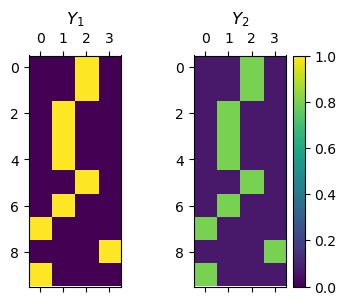

In [30]:
# Label Smoothing by Code

N    = 10                         #<! Number of samples
C    = 4                          #<! Number of classes (Labels)
vIdx = torch.randint(0, C, (N,))  #<! Reference labels

#<! mY1 (One Hot)
mY1 = torch.zeros(N, C) 
mY1 = torch.scatter(mY1, 1, torch.unsqueeze(vIdx, 1), 1.0)

#<! mY2 (Smooth)
ϵ   = 0.2
mY2 = torch.full((N, C), ϵ / (C - 1))
mY2 = torch.scatter(mY2, 1, torch.unsqueeze(vIdx, 1), 1 - ϵ)

hF, hA = plt.subplots(1, 2, figsize = (4, 3))
hImg = hA[0].matshow(mY1, vmin = 0, vmax = 1)
hImg = hA[1].matshow(mY2, vmin = 0, vmax = 1)
hA[0].set_title('$Y_1$')
hA[1].set_title('$Y_2$')
hF.colorbar(hImg)

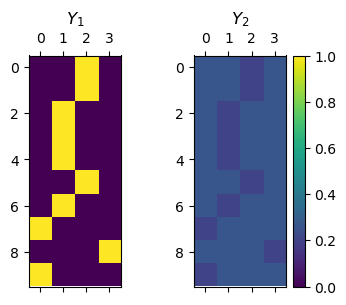

In [31]:
#<! mY2 (Smooth)
ϵ   = 0.8
mY2 = torch.full((N, C), ϵ / (C - 1))
mY2 = torch.scatter(mY2, 1, torch.unsqueeze(vIdx, 1), 1 - ϵ)

hF, hA = plt.subplots(1, 2, figsize = (4, 3))
hImg = hA[0].matshow(mY1, vmin = 0, vmax = 1)
hImg = hA[1].matshow(mY2, vmin = 0, vmax = 1)
hA[0].set_title('$Y_1$')
hA[1].set_title('$Y_2$')
hF.colorbar(hImg)

In [23]:
# Run Device

runDevice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #<! The 1st CUDA device


In [24]:
# Loss and Score Function
lϵ = [0.0, 0.1]

hS = MulticlassAccuracy(num_classes = len(lClass), average = 'micro')

hS = hS.to(runDevice)

In [25]:
# Training Loop

dModelHist = {}

for ii, ϵ in enumerate(lϵ):
    modelName = f'ϵ={ϵ:3.2f}'
    print(f'Training model: {modelName}')
    hL = nn.CrossEntropyLoss(label_smoothing = ϵ)
    oRunModel = copy.deepcopy(oModel) #<! Transfer model to device
    oRunModel = oRunModel.to(runDevice)
    oOpt = torch.optim.AdamW(oRunModel.parameters(), lr = 1e-3, betas = (0.9, 0.99), weight_decay = 1e-2) #<! Define optimizer
    oSch = torch.optim.lr_scheduler.OneCycleLR(oOpt, max_lr = 5e-2, total_steps = numEpochs)
    _, lTrainLoss, lTrainScore, lValLoss, lValScore, lLearnRate = TrainModel(oRunModel, dlTrain, dlVal, oOpt, numEpochs, hL, hS, oSch = oSch)

    # oSch = torch.optim.lr_scheduler.OneCycleLR(oOpt, max_lr = 5e-2, total_steps = numEpochs * len(dlTrain))
    # _, lTrainLoss, lTrainScore, lValLoss, lValScore, lLearnRate = TrainModelSch(oRunModel, dlTrain, dlVal, oOpt, oSch, numEpochs, hL, hS)
    dModelHist[modelName] = lTrainLoss, lTrainScore, lValLoss, lValScore, lLearnRate

Training model: ϵ=0.00
Epoch    1 / 5 | Train Loss:  1.791 | Val Loss:  1.353 | Train Score:  0.353 | Val Score:  0.512 | Epoch Time: 32.08 | <-- Checkpoint! |
Epoch    2 / 5 | Train Loss:  2.258 | Val Loss:  1.845 | Train Score:  0.160 | Val Score:  0.267 | Epoch Time: 17.37 |
Epoch    3 / 5 | Train Loss:  1.815 | Val Loss:  1.503 | Train Score:  0.311 | Val Score:  0.442 | Epoch Time: 17.07 |
Epoch    4 / 5 | Train Loss:  1.520 | Val Loss:  1.259 | Train Score:  0.443 | Val Score:  0.541 | Epoch Time: 17.39 | <-- Checkpoint! |
Epoch    5 / 5 | Train Loss:  1.427 | Val Loss:  1.225 | Train Score:  0.478 | Val Score:  0.551 | Epoch Time: 17.24 | <-- Checkpoint! |
Training model: ϵ=0.10
Epoch    1 / 5 | Train Loss:  1.899 | Val Loss:  1.600 | Train Score:  0.358 | Val Score:  0.507 | Epoch Time: 17.53 | <-- Checkpoint! |
Epoch    2 / 5 | Train Loss:  2.309 | Val Loss:  2.068 | Train Score:  0.145 | Val Score:  0.201 | Epoch Time: 17.17 |
Epoch    3 / 5 | Train Loss:  1.991 | Val Loss:  

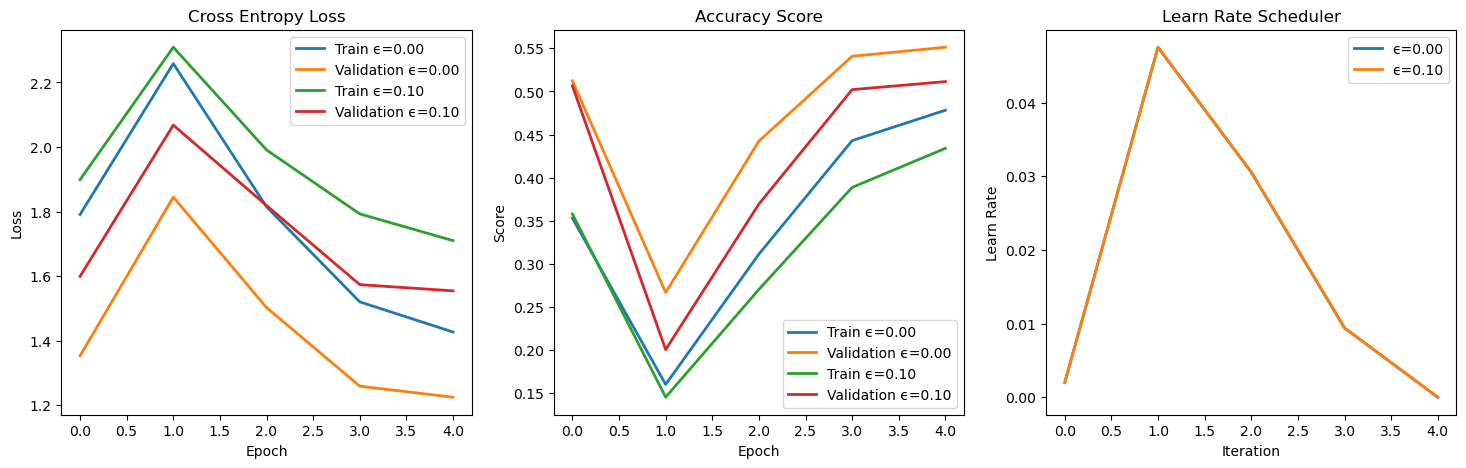

In [26]:
# Plot Training Phase

hF, vHa = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 5))
vHa = np.ravel(vHa)

for modelKey in dModelHist:
    hA = vHa[0]
    hA.plot(dModelHist[modelKey][0], lw = 2, label = f'Train {modelKey}')
    hA.plot(dModelHist[modelKey][2], lw = 2, label = f'Validation {modelKey}')
    hA.set_title('Cross Entropy Loss')
    hA.set_xlabel('Epoch')
    hA.set_ylabel('Loss')
    hA.legend()

    hA = vHa[1]
    hA.plot(dModelHist[modelKey][1], lw = 2, label = f'Train {modelKey}')
    hA.plot(dModelHist[modelKey][3], lw = 2, label = f'Validation {modelKey}')
    hA.set_title('Accuracy Score')
    hA.set_xlabel('Epoch')
    hA.set_ylabel('Score')
    hA.legend()

    hA = vHa[2]
    hA.plot(lLearnRate, lw = 2, label = f'{modelKey}')
    hA.set_title('Learn Rate Scheduler')
    hA.set_xlabel('Iteration')
    hA.set_ylabel('Learn Rate')
    hA.legend()

* <font color='red'>(**?**)</font> Is the loss landscape comparable between the 2 training phases?